In [1]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random
import time
import matplotlib.pyplot as plt
import implicit
import evaluation_measures as ev

train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)

In [2]:
alpha = 30
train_ui*=alpha
train_iu=train_ui.transpose().tocsr()

In [6]:
model = implicit.als.AlternatingLeastSquares(factors=200, regularization=0.1, iterations=10)
model.fit(train_iu)

In [7]:
def top_k_recommendations(model, user_code_id, item_code_id, topK=10):
    recommendations=[]
    for u in range(train_ui.shape[0]):
        u_recommended_items=model.recommend(u, train_ui, N=10, filter_already_liked_items=True)
        recommendations.append([user_code_id[u]]+list(chain(*u_recommended_items)))
    reco=pd.DataFrame(recommendations)
    reco.iloc[:,1::2]=reco.iloc[:,1::2].applymap(lambda x: item_code_id[x])
    return reco

def estimate(model, user_code_id, item_code_id, test_ui):
    result=[]
    for user, item in zip(*test_ui.nonzero()):
        result.append([user_code_id[user], item_code_id[item], 
            model.rank_items(userid=user, user_items=train_ui, selected_items=[item])[0][1]])
    return result

In [8]:
reco=top_k_recommendations(model, user_code_id, item_code_id, topK=10)
reco.to_csv('Recommendations generated/ml-100k/Ready_ImplicitALS_reco.csv', index=False, header=False)

estimations_df=pd.DataFrame(estimate(model, user_code_id, item_code_id, test_ui))
estimations_df.to_csv('Recommendations generated/ml-100k/Ready_ImplicitALS_estimations.csv', index=False, header=False)

In [9]:
import evaluation_measures as ev
import imp
imp.reload(ev)

estimations_df=pd.read_csv('Recommendations generated/ml-100k/Ready_ImplicitALS_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Ready_ImplicitALS_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])
#also you can just type ev.evaluate_all(estimations_df, reco) - I put above values as default

943it [00:00, 7273.15it/s]


RMSE       MAE  precision    recall       F_1      F_05  \
0  3.266101  3.065824   0.255037  0.188653  0.176852  0.201189   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.166631      0.214925  0.305908  0.172546  0.523871  0.591709   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.889714           1.0       0.502886  5.722957  0.827507

### Hiperparameters tuning

### Number of latent factors

In [10]:
from tqdm import tqdm
result=[]
for factors in tqdm([i for i in np.arange(25,400,25)]):
    train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
    test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
    train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)
    
    train_ui*=100
    train_iu=train_ui.transpose().tocsr()
    
    model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=0.1, iterations=10)
    model.fit(train_iu, show_progress=False)
    
    reco=top_k_recommendations(model, user_code_id, item_code_id, topK=10)
    estimations_df=pd.DataFrame(estimate(model, user_code_id, item_code_id, test_ui))
    
    to_append=ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=np.array(reco),
            super_reactions=[4,5])
    to_append.insert(0, "Factors", factors)
    result.append(to_append)
    
result=pd.concat(result)
result

  0%|          | 0/15 [00:00<?, ?it/s]
0it [00:00, ?it/s]
943it [00:00, 7627.67it/s]
  7%|▋         | 1/15 [00:01<00:24,  1.72s/it]
0it [00:00, ?it/s]
943it [00:00, 7209.44it/s]
 13%|█▎        | 2/15 [00:03<00:22,  1.73s/it]
0it [00:00, ?it/s]
943it [00:00, 7676.76it/s]
 20%|██        | 3/15 [00:05<00:20,  1.73s/it]
0it [00:00, ?it/s]
943it [00:00, 6846.90it/s]
 27%|██▋       | 4/15 [00:06<00:19,  1.74s/it]
0it [00:00, ?it/s]
943it [00:00, 7293.55it/s]
 33%|███▎      | 5/15 [00:08<00:17,  1.78s/it]
0it [00:00, ?it/s]
943it [00:00, 7443.26it/s]
 40%|████      | 6/15 [00:10<00:16,  1.81s/it]
0it [00:00, ?it/s]
943it [00:00, 6977.23it/s]
 47%|████▋     | 7/15 [00:12<00:14,  1.85s/it]
0it [00:00, ?it/s]
943it [00:00, 7493.35it/s]
 53%|█████▎    | 8/15 [00:14<00:13,  1.86s/it]
0it [00:00, ?it/s]
943it [00:00, 7549.26it/s]
 60%|██████    | 9/15 [00:16<00:11,  1.90s/it]
0it [00:00, ?it/s]
943it [00:00, 7077.91it/s]
 67%|██████▋   | 10/15 [00:18<00:09,  1.98s/it]
0it [00:00, ?it/s]
943it [00:0

Factors      RMSE       MAE  precision    recall       F_1      F_05  \
0       25  2.846560  2.620794   0.105726  0.108047  0.090518  0.093488   
0       50  2.898666  2.677181   0.143690  0.138828  0.119410  0.125049   
0       75  2.944450  2.726341   0.171898  0.154471  0.135551  0.145599   
0      100  2.985948  2.769517   0.183775  0.155463  0.140189  0.152755   
0      125  3.017333  2.802986   0.198940  0.165227  0.149710  0.164644   
0      150  3.042801  2.830367   0.214528  0.168468  0.155574  0.173686   
0      175  3.063186  2.851980   0.218664  0.170133  0.157283  0.176077   
0      200  3.089628  2.878716   0.220042  0.168505  0.156406  0.176143   
0      225  3.102684  2.892941   0.221209  0.167369  0.155187  0.175486   
0      250  3.110198  2.901659   0.221421  0.166139  0.154255  0.175268   
0      275  3.123178  2.915596   0.234146  0.163006  0.158760  0.183134   
0      300  3.130343  2.923515   0.237116  0.167547  0.160936  0.185078   
0      325  3.141945  2.934988   0.232025  0.165168  0.157315  0.181076   
0      350  3.149635  2.943592   0.232662  0.167366  0.158349  0.181597   
0      375  3.161007  2.955454   0.234571  0.167177  0.159795  0.183107   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.061481      0.123853  0.116915  0.048083  0.203663  0.550716   
0         0.089700      0.154579  0.164112  0.074820  0.284589  0.566289   
0         0.104936      0.173039  0.195845  0.092338  0.337621  0.574228   
0         0.110193      0.167837  0.215259  0.106274  0.383384  0.574794   
0         0.127575      0.183066  0.234839  0.119023  0.416181  0.579735   
0         0.139378      0.189273  0.247685  0.126369  0.424573  0.581421   
0         0.141202      0.197503  0.254178  0.132146  0.435676  0.582275   
0         0.142597      0.188596  0.257188  0.134919  0.443163  0.581471   
0         0.140773      0.185437  0.256898  0.134811  0.441676  0.580896   
0         0.145064      0.193650  0.257955  0.136844  0.436043  0.580283   
0         0.152146      0.183701  0.270489  0.144723  0.472533  0.578769   
0         0.154292      0.192522  0.272852  0.149091  0.460155  0.581044   
0         0.147639      0.179435  0.272440  0.150512  0.462026  0.579861   
0         0.151717      0.186675  0.270835  0.146983  0.463859  0.580944   
0         0.150536      0.180057  0.269211  0.147040  0.451392  0.580851   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.624602      0.996819       0.715007  6.465360  0.644456  
0  0.750795      0.999258       0.664502  6.275680  0.699156  
0  0.802757      0.999894       0.598846  6.057144  0.757071  
0  0.813362      1.000000       0.558442  5.920294  0.788368  
0  0.830329      0.999788       0.532468  5.813474  0.811387  
0  0.856840      1.000000       0.507937  5.727541  0.825294  
0  0.854719      1.000000       0.497835  5.681921  0.833476  
0  0.845175      0.999894       0.490620  5.645500  0.838308  
0  0.855779      1.000000       0.474026  5.628248  0.842938  
0  0.851538      1.000000       0.482684  5.552392  0.850104  
0  0.853659      1.000000       0.460317  5.597279  0.847138  
0  0.841994      1.000000       0.457431  5.534284  0.855633  
0  0.840933      1.000000       0.451659  5.500822  0.860569  
0  0.853659      1.000000       0.458153  5.490997  0.860762  
0  0.851538      0.999894       0.460317  5.478842  0.860159

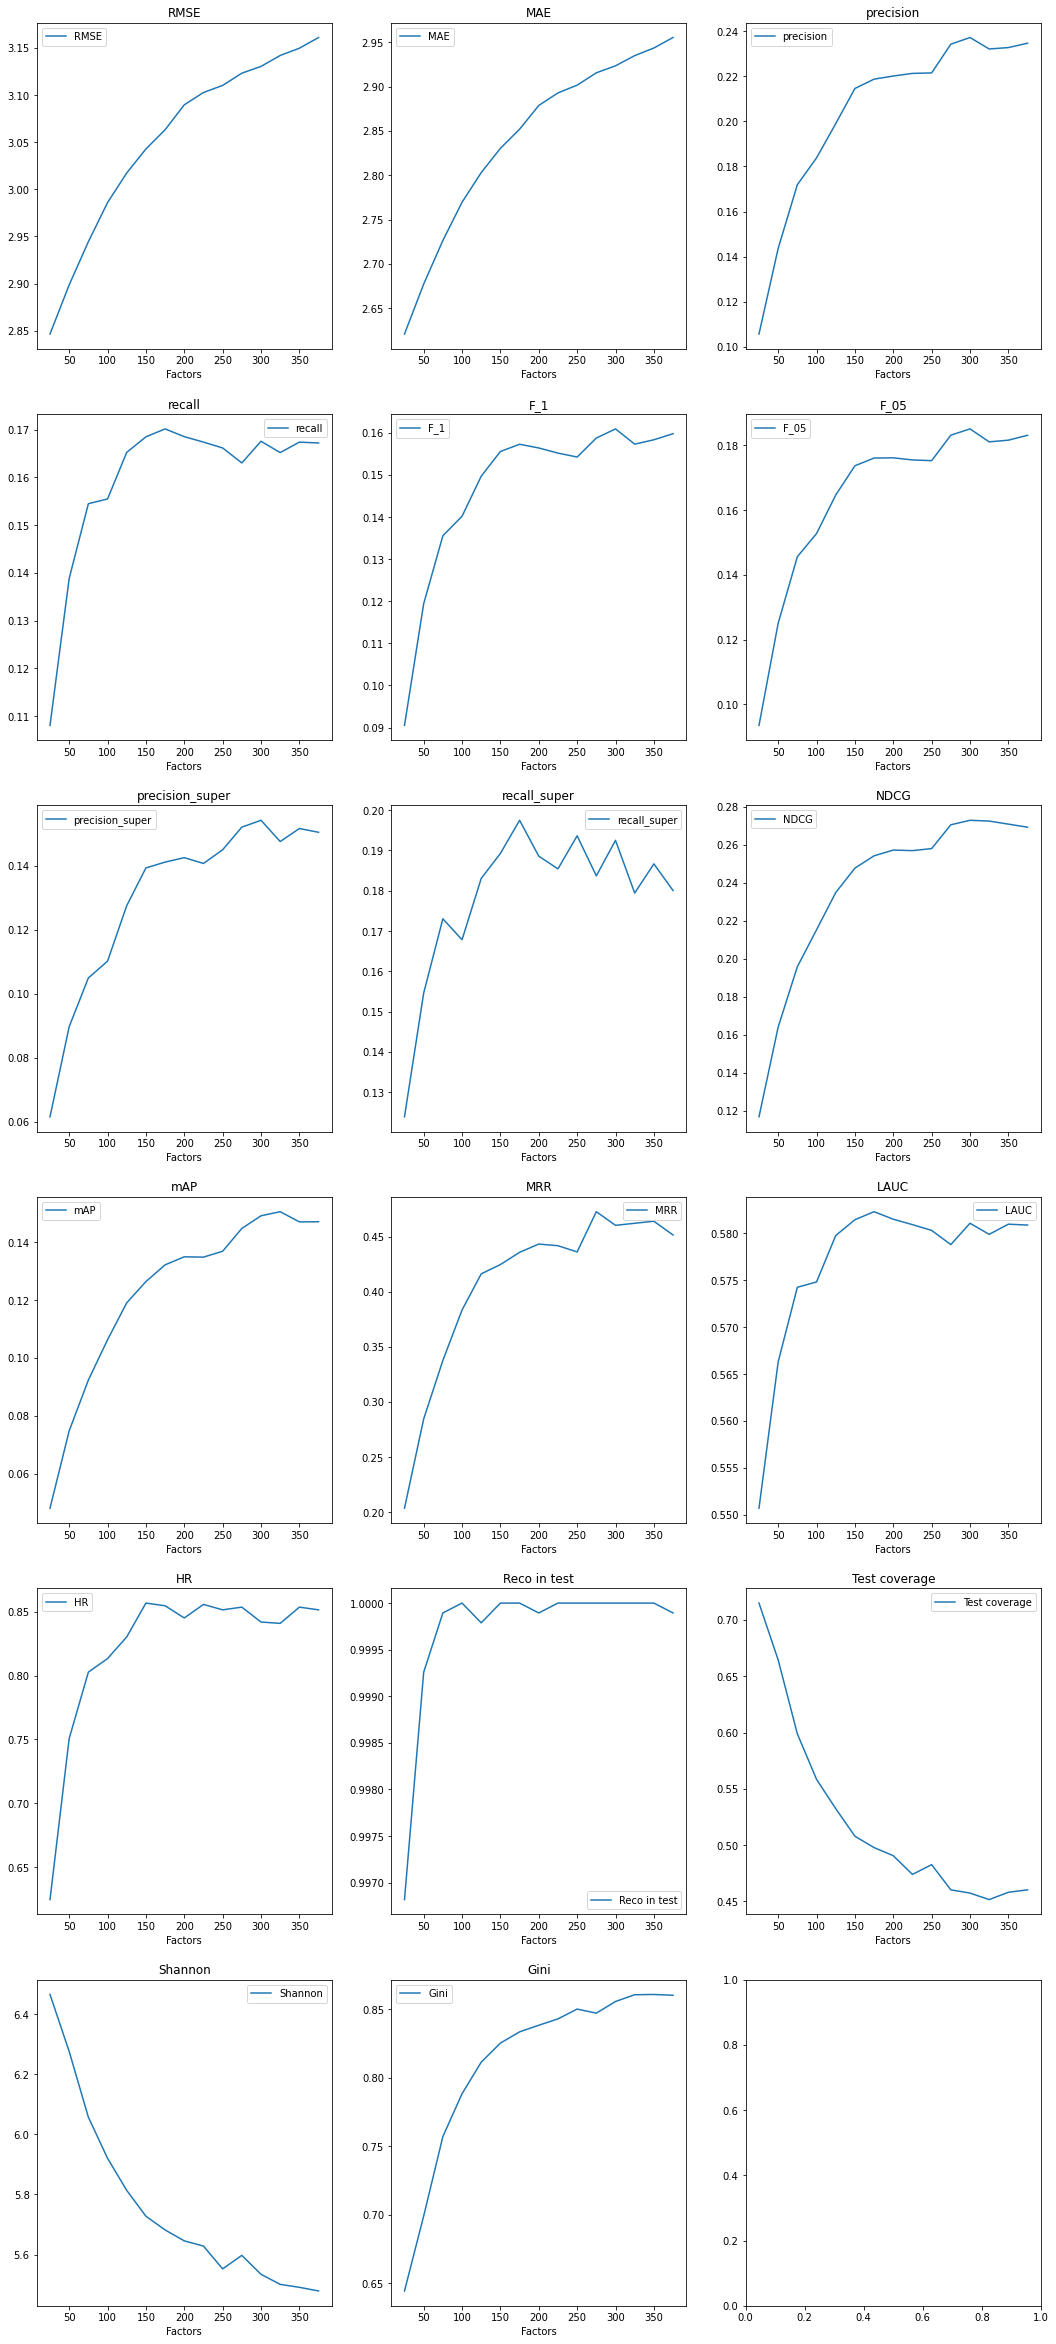

In [11]:
### import matplotlib.pyplot as plt

metrics=list(result.columns[[i not in ['Factors'] for i in result.columns]])

charts_per_row=6
charts_per_column=3

fig, axes = plt.subplots(nrows=charts_per_row, ncols=charts_per_column,figsize=(18, 7*charts_per_row ))
import itertools
to_iter=[i for i in itertools.product(range(charts_per_row), range(charts_per_column))]

for i in range(len(metrics)):
    df=result[['Factors', metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

### Alpha

In [12]:
from tqdm import tqdm
result=[]
for alpha in tqdm([1, 3, 7]+[i for i in np.arange(10,200,20)]):
    train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
    test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
    train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)
    
    train_ui*=alpha
    train_iu=train_ui.transpose().tocsr()
    
    model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=0.1, iterations=10)
    model.fit(train_iu, show_progress=False)
    
    reco=top_k_recommendations(model, user_code_id, item_code_id, topK=10)
    estimations_df=pd.DataFrame(estimate(model, user_code_id, item_code_id, test_ui))
    
    to_append=ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=np.array(reco),
            super_reactions=[4,5])
    to_append.insert(0, "Alpha", alpha)
    result.append(to_append)
    
result=pd.concat(result)
result

  0%|          | 0/13 [00:00<?, ?it/s]
0it [00:00, ?it/s]
943it [00:00, 7477.64it/s]
  8%|▊         | 1/13 [00:02<00:31,  2.61s/it]
0it [00:00, ?it/s]
943it [00:00, 7366.79it/s]
 15%|█▌        | 2/13 [00:05<00:28,  2.58s/it]
0it [00:00, ?it/s]
943it [00:00, 7482.23it/s]
 23%|██▎       | 3/13 [00:07<00:25,  2.58s/it]
0it [00:00, ?it/s]
943it [00:00, 7401.22it/s]
 31%|███       | 4/13 [00:10<00:23,  2.58s/it]
0it [00:00, ?it/s]
943it [00:00, 6881.15it/s]
 38%|███▊      | 5/13 [00:12<00:20,  2.59s/it]
0it [00:00, ?it/s]
943it [00:00, 6983.24it/s]
 46%|████▌     | 6/13 [00:15<00:17,  2.56s/it]
0it [00:00, ?it/s]
943it [00:00, 6942.52it/s]
 54%|█████▍    | 7/13 [00:17<00:15,  2.55s/it]
0it [00:00, ?it/s]
943it [00:00, 7235.29it/s]
 62%|██████▏   | 8/13 [00:20<00:12,  2.53s/it]
0it [00:00, ?it/s]
943it [00:00, 7101.42it/s]
 69%|██████▉   | 9/13 [00:22<00:10,  2.53s/it]
0it [00:00, ?it/s]
943it [00:00, 7151.07it/s]
 77%|███████▋  | 10/13 [00:25<00:07,  2.51s/it]
0it [00:00, ?it/s]
943it [00:0

Alpha      RMSE       MAE  precision    recall       F_1      F_05  \
0      1  3.667401  3.489285   0.097349  0.072948  0.068621  0.077305   
0      3  3.628888  3.449626   0.142418  0.099087  0.095250  0.109958   
0      7  3.557600  3.376851   0.219618  0.145557  0.142994  0.167132   
0     10  3.507947  3.325719   0.255143  0.174045  0.168845  0.196237   
0     30  3.359788  3.168804   0.271262  0.191732  0.184405  0.211858   
0     50  3.273254  3.075697   0.265217  0.188703  0.179673  0.206738   
0     70  3.214601  3.012592   0.249629  0.175516  0.169005  0.194526   
0     90  3.174570  2.970676   0.244751  0.171145  0.164571  0.190198   
0    110  3.138148  2.931536   0.229692  0.164445  0.156457  0.179431   
0    130  3.114034  2.904438   0.225133  0.158999  0.152533  0.175715   
0    150  3.089790  2.880051   0.219300  0.155447  0.149104  0.171284   
0    170  3.070975  2.858780   0.216331  0.158103  0.149290  0.170456   
0    190  3.055852  2.843086   0.207317  0.149367  0.142287  0.162816   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.054614      0.071923  0.115946  0.050679  0.253435  0.533195   
0         0.086159      0.105848  0.170625  0.082786  0.347226  0.546454   
0         0.142489      0.165904  0.259872  0.143493  0.465442  0.570010   
0         0.170386      0.197982  0.307968  0.179416  0.542711  0.584408   
0         0.182833      0.228368  0.323901  0.187954  0.549506  0.593310   
0         0.174571      0.214519  0.315700  0.182200  0.532506  0.591772   
0         0.162661      0.202930  0.292262  0.163398  0.501654  0.585098   
0         0.162876      0.199225  0.283543  0.156381  0.479877  0.582885   
0         0.151931      0.191769  0.267423  0.144461  0.460625  0.579477   
0         0.149571      0.183970  0.258418  0.138422  0.438959  0.576722   
0         0.144635      0.176639  0.250976  0.130455  0.445470  0.574904   
0         0.141416      0.181804  0.247910  0.129594  0.427431  0.576235   
0         0.132833      0.163011  0.234566  0.119859  0.405354  0.571824   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.577943      0.994804       0.730880  6.699624  0.535431  
0  0.698834      0.994910       0.712121  6.639279  0.568322  
0  0.820785      0.997137       0.629870  6.325220  0.691428  
0  0.863203      0.998197       0.579365  6.075866  0.756129  
0  0.889714      0.999470       0.494949  5.612128  0.840695  
0  0.872747      1.000000       0.466089  5.493297  0.856776  
0  0.862142      0.999788       0.450938  5.482008  0.860232  
0  0.849417      0.999894       0.450216  5.491347  0.861497  
0  0.845175      1.000000       0.458153  5.474450  0.861871  
0  0.826087      1.000000       0.449495  5.474419  0.862658  
0  0.851538      1.000000       0.461760  5.473903  0.864300  
0  0.831389      1.000000       0.463925  5.500412  0.857992  
0  0.831389      1.000000       0.467532  5.523357  0.857033

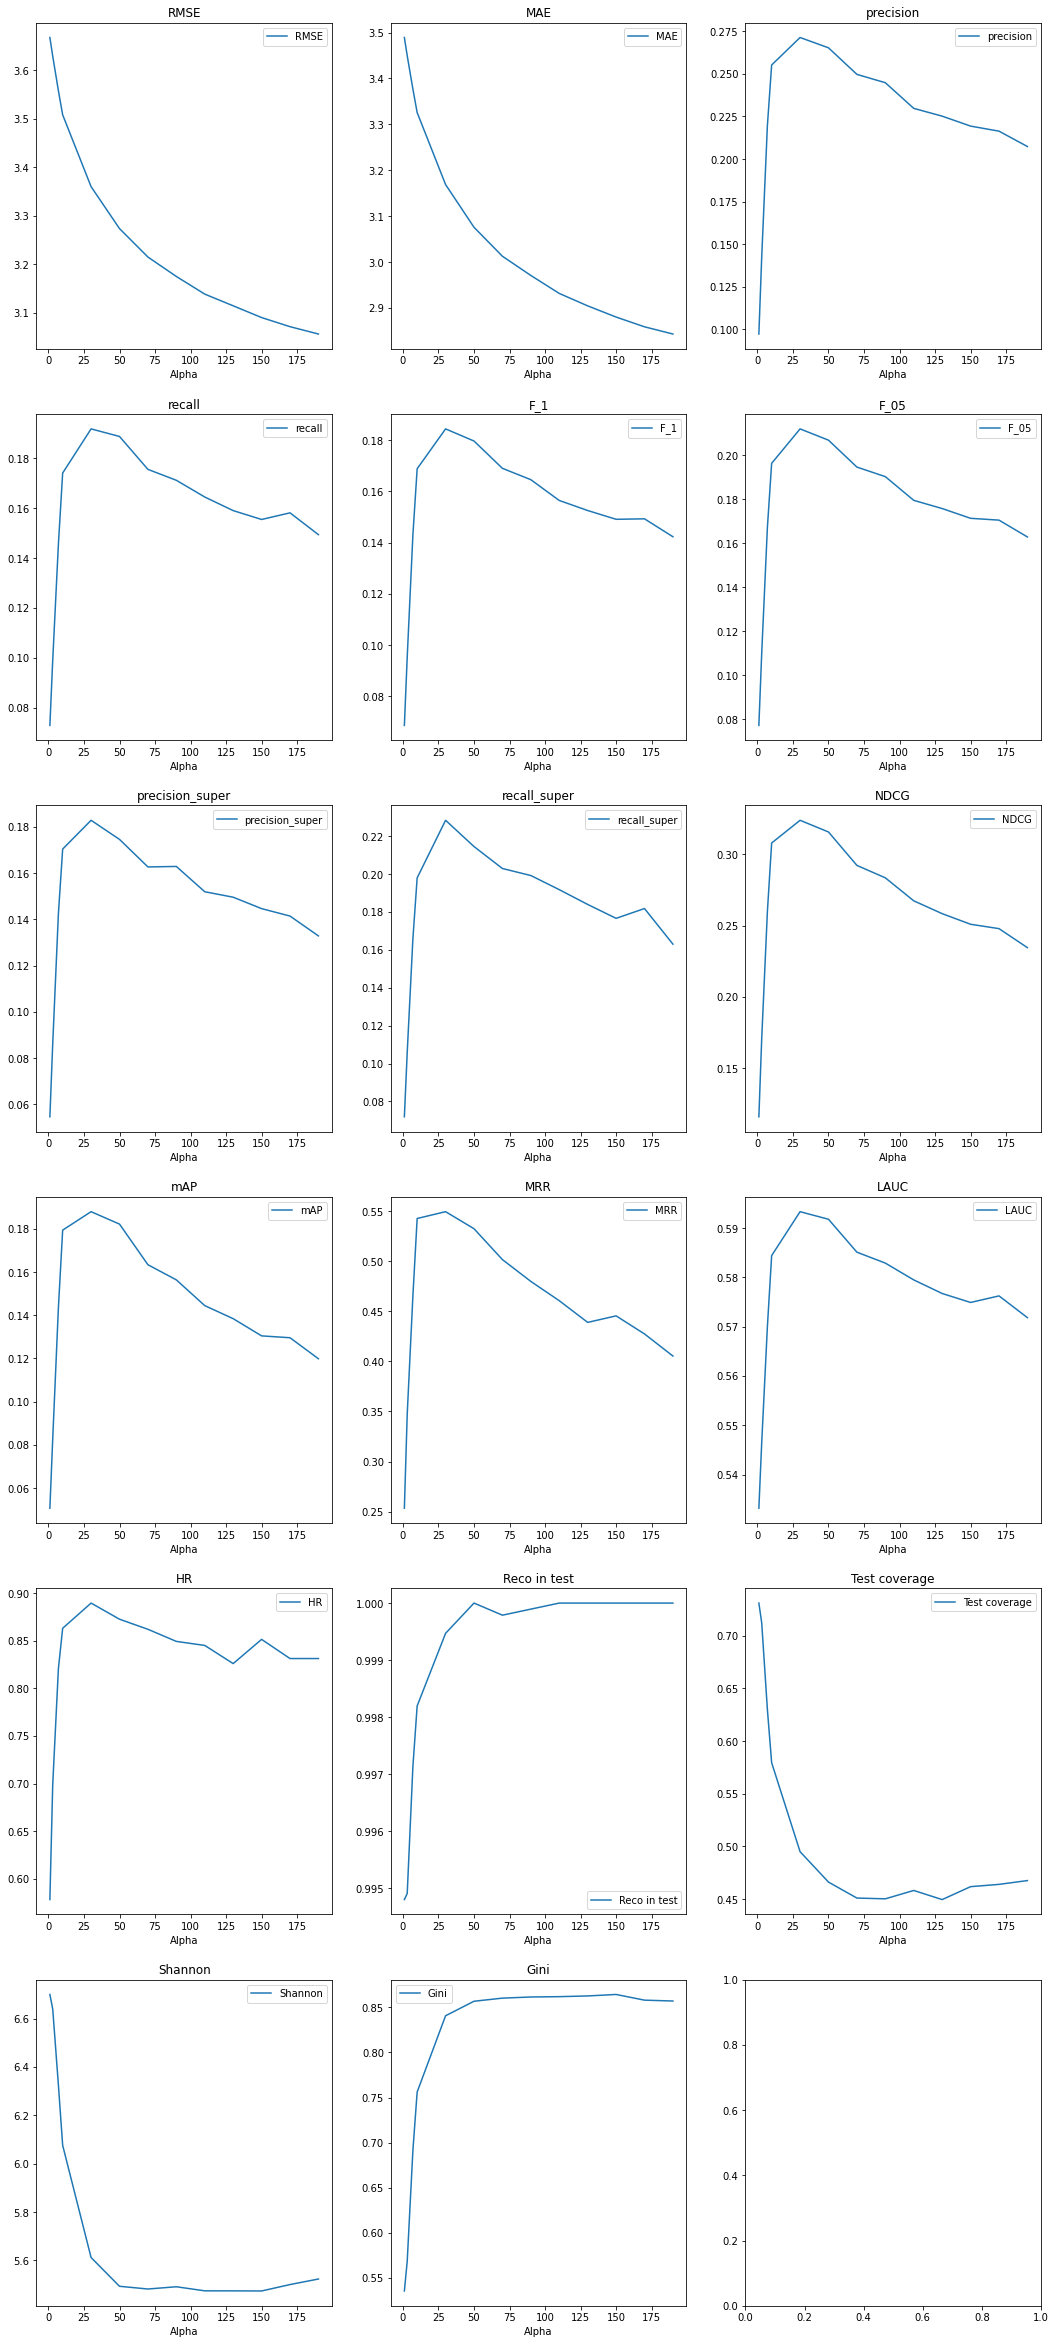

In [13]:
### import matplotlib.pyplot as plt

metrics=list(result.columns[[i not in ['Alpha'] for i in result.columns]])

charts_per_row=6
charts_per_column=3

fig, axes = plt.subplots(nrows=charts_per_row, ncols=charts_per_column,figsize=(18, 7*charts_per_row ))
import itertools
to_iter=[i for i in itertools.product(range(charts_per_row), range(charts_per_column))]

for i in range(len(metrics)):
    df=result[['Alpha', metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

In [14]:
import evaluation_measures as ev

dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 7384.16it/s]
943it [00:00, 7881.42it/s]
943it [00:00, 8618.41it/s]
943it [00:00, 7851.41it/s]
943it [00:00, 8173.68it/s]
943it [00:00, 7964.65it/s]
943it [00:00, 6842.04it/s]
943it [00:00, 6556.41it/s]
943it [00:00, 8900.33it/s]


Model        RMSE         MAE  precision    recall  \
0   Ready_LightFMpureMF    7.953192    7.462008   0.334464  0.219997   
0         Ready_LightFM  162.707436  160.855483   0.340827  0.217682   
0     Ready_ImplicitALS    3.266101    3.065824   0.255037  0.188653   
0           Self_TopPop    2.508258    2.217909   0.188865  0.116919   
0  Ready_LightFMcontent  182.471340  180.405210   0.160339  0.101224   
0        Ready_Baseline    0.949459    0.752487   0.091410  0.037652   
0        Self_GlobalAvg    1.125760    0.943534   0.061188  0.025968   
0          Ready_Random    1.514355    1.216383   0.049735  0.022300   
0       Self_BaselineUI    0.967585    0.762740   0.000954  0.000170   

        F_1      F_05  precision_super  recall_super      NDCG       mAP  \
0  0.217225  0.254981         0.233798      0.266952  0.398778  0.263058   
0  0.217990  0.258010         0.243884      0.260663  0.403850  0.268266   
0  0.176852  0.201189         0.166631      0.214925  0.305908  0.172546   
0  0.118732  0.141584         0.130472      0.137473  0.214651  0.111707   
0  0.102198  0.121074         0.102682      0.112455  0.180079  0.087429   
0  0.046030  0.061286         0.079614      0.056463  0.095957  0.043178   
0  0.031383  0.041343         0.040558      0.032107  0.067695  0.027470   
0  0.025782  0.033598         0.028219      0.021751  0.054383  0.021119   
0  0.000278  0.000463         0.000644      0.000189  0.000752  0.000168   

        MRR      LAUC        HR  Reco in test  Test coverage   Shannon  \
0  0.629129  0.607709  0.913043      1.000000       0.275613  5.085818   
0  0.637590  0.606568  0.898197      1.000000       0.351371  5.366291   
0  0.523871  0.591709  0.889714      1.000000       0.502886  5.722957   
0  0.400939  0.555546  0.765642      1.000000       0.038961  3.159079   
0  0.337825  0.547572  0.704136      0.974973       0.264791  4.909893   
0  0.198193  0.515501  0.437964      1.000000       0.033911  2.836513   
0  0.171187  0.509546  0.384942      1.000000       0.025974  2.711772   
0  0.133978  0.507680  0.339343      0.986957       0.177489  5.088670   
0  0.001677  0.496424  0.009544      0.600530       0.005051  1.803126   

       Gini  
0  0.913665  
0  0.885046  
0  0.827507  
0  0.987317  
0  0.926201  
0  0.991139  
0  0.992003  
0  0.907676  
0  0.996380